<span style="font-family: Arial; font-weight:bold;font-size:2em;color:#00b3e5;"> Code Spaze task 1b Customer Sales prediction
    
<span style="font-family: Arial; font-weight:bold;font-size:1.5em;color:#00b3e5;"> Submitted by
    
<span style="font-family: Arial; font-weight:bold;font-size:1.5em;color:#00b3e5;"> Shameer.Sutar


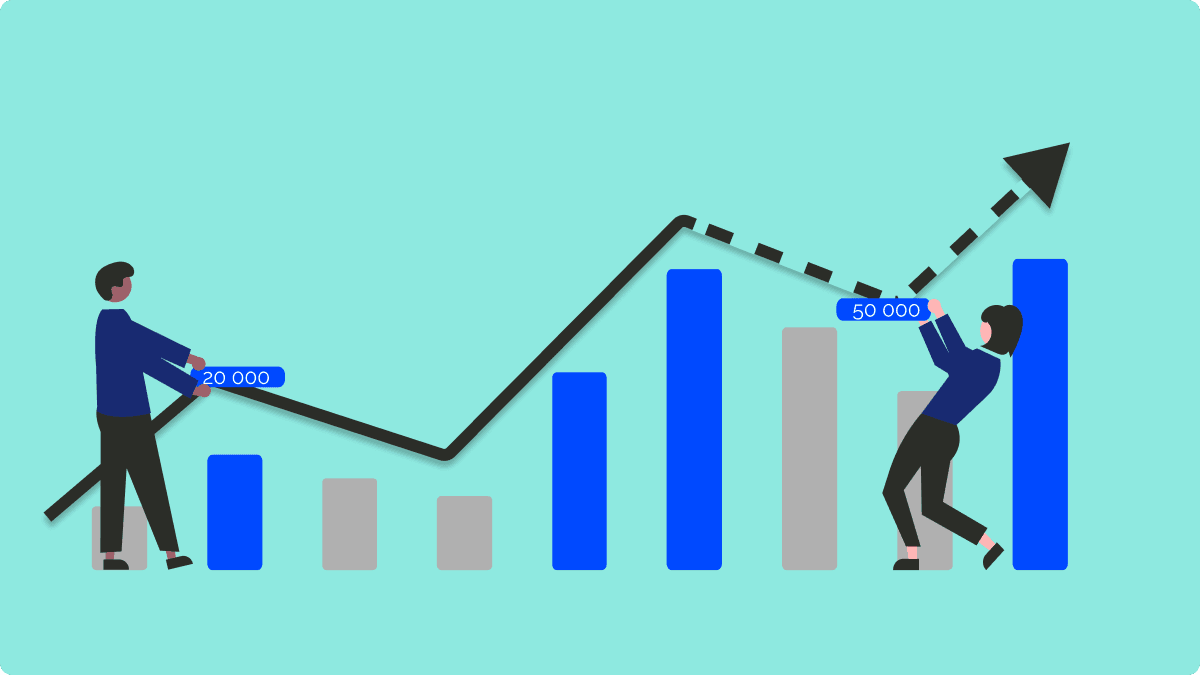

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import math
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error , mean_squared_error , r2_score
from xgboost import XGBRegressor
import optuna
from sklearn.preprocessing import StandardScaler
# Ignore warnings ;)
import warnings
warnings.simplefilter("ignore")

import pickle

# set seed for reproductibility
np.random.seed(0)

In [2]:
file_path = ('D:/CodeSpaze/sales/BigMart Sales Data.csv')
df = pd.read_csv(file_path)

In [3]:
df.head()

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30          Low Fat         0.016047   
1           DRC01         5.92          Regular         0.019278   
2           FDN15        17.50          Low Fat         0.016760   
3           FDX07        19.20          Regular         0.000000   
4           NCD19         8.93          Low Fat         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  182.0950            OUT010   
4              Household   53.8614            OUT013   

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                       1999      Medium               Tier 1   
1                       2009      Medium               Tier 3   
2                       1999      Medium               Tier 1   
3                       1998         NaN               Tier 3   
4                       1987        High               Tier 3   

         Outlet_Type  Item_Outlet_Sales  
0  Supermarket Type1          3735.1380  
1  Supermarket Type2           443.4228  
2  Supermarket Type1          2097.2700  
3      Grocery Store           732.3800  
4  Supermarket Type1           994.7052

In [4]:
df.Item_Type.value_counts()

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

In [5]:
# shape attribute tells us the number of observations and variables we have in the data set.
df.shape

(8523, 12)

**in our dataset there are 8523 different items with 12 features.**

In [6]:
# info() is used to check the Information about the data and the datatypes of each respective attribute
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


**Features Description:**

* **Numerical features:**
    - **Item_Weight       :** Weight of the product or item.
    - **Item_Visibility   :** The % of the total display area of all products in a store allocated to the particular product.
    - **Item_MRP          :** Maximum Retail Price (list price) of the product
    - **Outlet_Establishment_Year :** The year in which the store was established.
    - **Item_Outlet_Sales :** sales of the product in a particular store. This is the target variable to be predicted.
    

* **Categorical features:**
    - **Item_Identifier :** Unique product ID (we would want to drop this column later) 
    - **Item_Fat_Content :** Whether the product is low, fat or not
    - **Item_Type         :** The category to which the product belongs.
    - **Outlet_Identifier :** Unique store ID
    - **Outlet_Size    :** The size of the store in terms of ground area covered.
    - **Outlet_Location_Type :** The type of city in which the store is located.
    - **Outlet_Type :** Whether the outlet is just a grocery store or some sort of supermarket.

In [7]:
# The describe() method help to see data spread for numerical values by default : min, max, mean, percentiles...
# but we can use the argument include='all' to see the descriptive stats about all types of variables
df.describe(include='all')

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
count             8523  7060.000000             8523      8523.000000   
unique            1559          NaN                5              NaN   
top              FDW13          NaN          Low Fat              NaN   
freq                10          NaN             5089              NaN   
mean               NaN    12.857645              NaN         0.066132   
std                NaN     4.643456              NaN         0.051598   
min                NaN     4.555000              NaN         0.000000   
25%                NaN     8.773750              NaN         0.026989   
50%                NaN    12.600000              NaN         0.053931   
75%                NaN    16.850000              NaN         0.094585   
max                NaN    21.350000              NaN         0.328391   

                    Item_Type     Item_MRP Outlet_Identifier  \
count                    8523  8523.000000              8523   
unique                     16          NaN                10   
top     Fruits and Vegetables          NaN            OUT027   
freq                     1232          NaN               935   
mean                      NaN   140.992782               NaN   
std                       NaN    62.275067               NaN   
min                       NaN    31.290000               NaN   
25%                       NaN    93.826500               NaN   
50%                       NaN   143.012800               NaN   
75%                       NaN   185.643700               NaN   
max                       NaN   266.888400               NaN   

        Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
count                 8523.000000        6113                 8523   
unique                        NaN           3                    3   
top                           NaN      Medium               Tier 3   
freq                          NaN        2793                 3350   
mean                  1997.831867         NaN                  NaN   
std                      8.371760         NaN                  NaN   
min                   1985.000000         NaN                  NaN   
25%                   1987.000000         NaN                  NaN   
50%                   1999.000000         NaN                  NaN   
75%                   2004.000000         NaN                  NaN   
max                   2009.000000         NaN                  NaN   

              Outlet_Type  Item_Outlet_Sales  
count                8523        8523.000000  
unique                  4                NaN  
top     Supermarket Type1                NaN  
freq                 5577                NaN  
mean                  NaN        2181.288914  
std                   NaN        1706.499616  
min                   NaN          33.290000  
25%                   NaN         834.247400  
50%                   NaN        1794.331000  
75%                   NaN        3101.296400  
max                   NaN       13086.964800

In [8]:
# get the number of missing datapoints per column
df.isnull().sum().sort_values(ascending=False)

Outlet_Size                  2410
Item_Weight                  1463
Item_Identifier                 0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

We can observe that we are having:
* **2410 missing values in the Outlet_Size feature** which is a categorical feature. 
* **1463 missing values in the Item_Weight feature**


For dealing with missing values, you'll need to use our intuition. Generally to figure out why the values are missing, we can ask ourself:
> Are these values missing because they weren't recorded or because they does't exist?

- **Doesn't exist   :** then we can keep them as NaN or simply drop them.
- **Weren't recorded:** then we can do imputation using different techniques. I'll choose between mean and mode imputation.

In [9]:
# maybe we should consider the 'Outlet_Establishment_Year' column as a categorical column
#train['Outlet_Establishment_Year'].value_counts()
#train['Outlet_Establishment_Year'] = train['Outlet_Establishment_Year'].astype(str)
df.Outlet_Establishment_Year

0       1999
1       2009
2       1999
3       1998
4       1987
        ... 
8518    1987
8519    2002
8520    2004
8521    2009
8522    1997
Name: Outlet_Establishment_Year, Length: 8523, dtype: int64

In [10]:
df['Outlet_Establishment_Year'].dtype

dtype('int64')

In [11]:
df['Outlet_Identifier'].value_counts() 

OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: Outlet_Identifier, dtype: int64

**This "Outlet_Identifier" feature can be extremely important for the modelling part** since there are only ten(10) values corresponding exactly to the ten(10) stores in which the data have been collected.

# Exploratory Data Analysis - EDA

## Univariate Analysis

### Numerical columns

In [12]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_cols

['Item_Weight',
 'Item_Visibility',
 'Item_MRP',
 'Outlet_Establishment_Year',
 'Item_Outlet_Sales']

In [13]:
df.describe().T

count         mean          std       min  \
Item_Weight                7060.0    12.857645     4.643456     4.555   
Item_Visibility            8523.0     0.066132     0.051598     0.000   
Item_MRP                   8523.0   140.992782    62.275067    31.290   
Outlet_Establishment_Year  8523.0  1997.831867     8.371760  1985.000   
Item_Outlet_Sales          8523.0  2181.288914  1706.499616    33.290   

                                   25%          50%          75%           max  
Item_Weight                   8.773750    12.600000    16.850000     21.350000  
Item_Visibility               0.026989     0.053931     0.094585      0.328391  
Item_MRP                     93.826500   143.012800   185.643700    266.888400  
Outlet_Establishment_Year  1987.000000  1999.000000  2004.000000   2009.000000  
Item_Outlet_Sales           834.247400  1794.331000  3101.296400  13086.964800

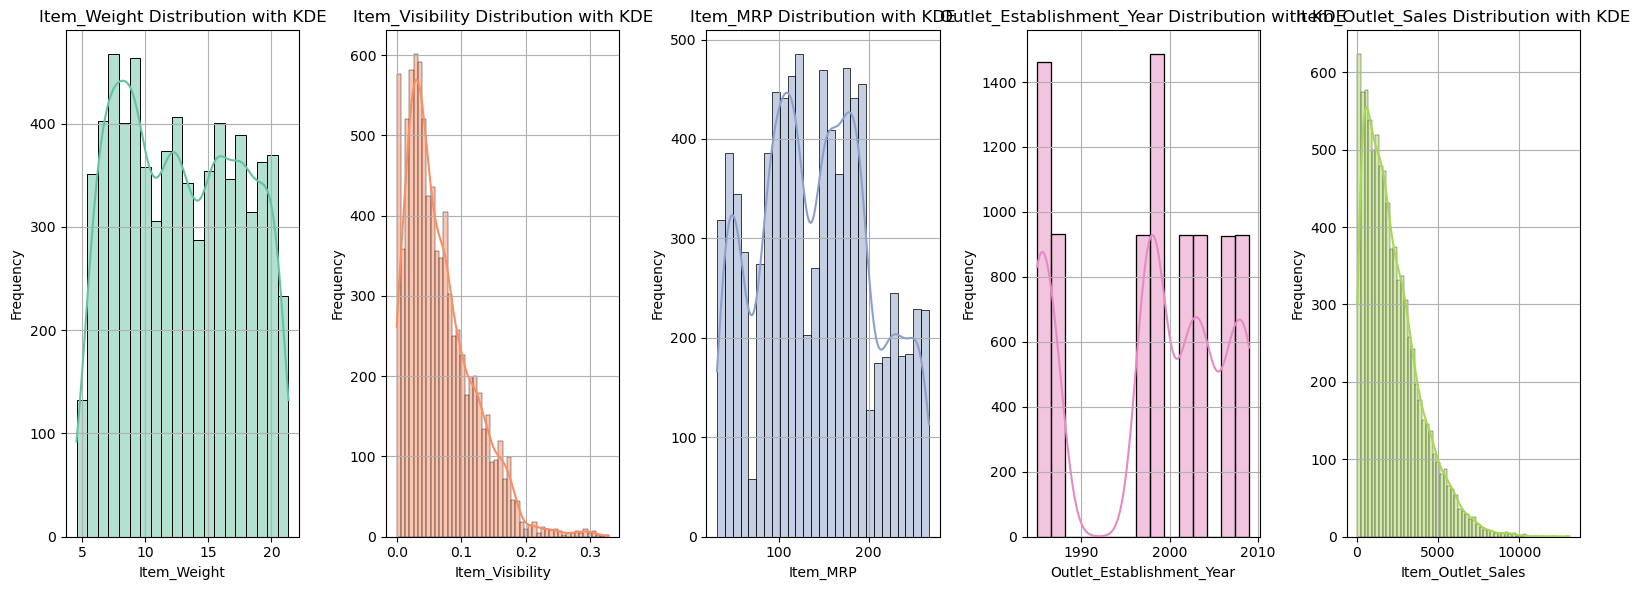

In [14]:
# Set a color palette for the histograms
colors = sns.color_palette("Set2", len(numeric_cols[:5]))

# Create subplots with appropriate figure size
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(16, 6))

# Loop through each column and plot the histogram with KDE
for index, col in enumerate(numeric_cols[:5]):
    sns.histplot(df[col], kde=True, ax=ax[index], color=colors[index])
    ax[index].set_title(f'{col} Distribution with KDE')
    ax[index].set_xlabel(col)
    ax[index].set_ylabel('Frequency')
    ax[index].grid(True)  # Add grid for better readability

plt.tight_layout() 
plt.show()

**Observations:**
- We observe that the item weight range from 5 Kg to 20 Kg.
- Item_Visibility feature is right skewed.
- There are more products in the range of 100 MRP - 180 MRP in the Item_MRP feature
- We can observe that a lots of stores have been established in the years 1985, 1998 etc... and there was no store establishment between 1990 and 1995.
- Item_Outlet_Sales feature is right skewed. We can may be try to do a transformation in order to obtain a normal  Gaussian distribution

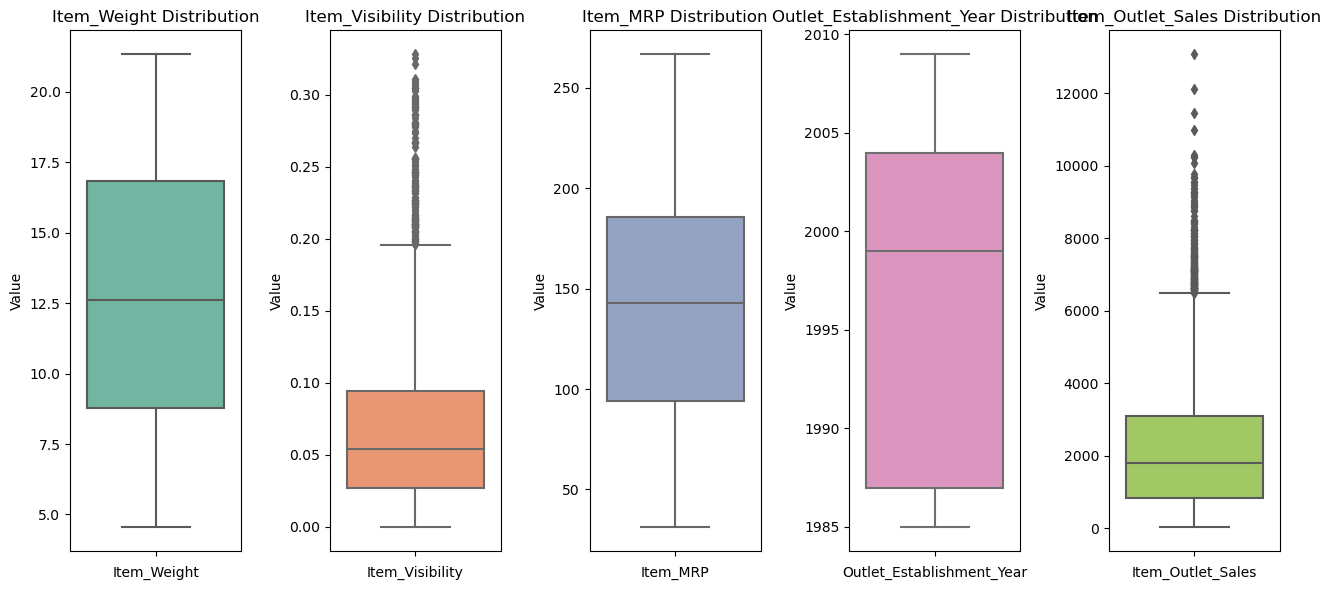

In [15]:
colors = sns.color_palette("Set2", len(numeric_cols))  
fig, ax = plt.subplots(nrows=1, ncols=len(numeric_cols), figsize=(13, 6))

# Loop through each column and plot the boxplot
for index, col in enumerate(numeric_cols):
    sns.boxplot(data=df, y=col, ax=ax[index], color=colors[index])
    ax[index].set_title(f'{col} Distribution')
    ax[index].set_xlabel(col)
    ax[index].set_ylabel('Value')

plt.tight_layout()  
plt.show()

**Observations:**
- There are almost no outliers in the Item_Weight, Item_MRP and Outlet_Establishment_Year features.
- Conversely there are some **outliers to be removed in the Item_Visibility and Item_Outlet_Sales features.**

### Categorical columns

In [16]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols

['Item_Identifier',
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [17]:
categorical_cols_to_display = [ 
                                 'Item_Fat_Content',
                                 'Item_Type',
                                 'Outlet_Size',
                                 'Outlet_Location_Type',
                                 'Outlet_Type'
                                ]
for col in categorical_cols_to_display:
    print(f"Number of values in the {col} column is:\n{df[col].value_counts() }")
    print("--" * 30)

Number of values in the Item_Fat_Content column is:
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64
------------------------------------------------------------
Number of values in the Item_Type column is:
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64
------------------------------------------------------------
Number of values in the Outlet_Size column is:
Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64
------------------------------

In [18]:
df['Outlet_Location_Type'].unique().tolist()

['Tier 1', 'Tier 3', 'Tier 2']

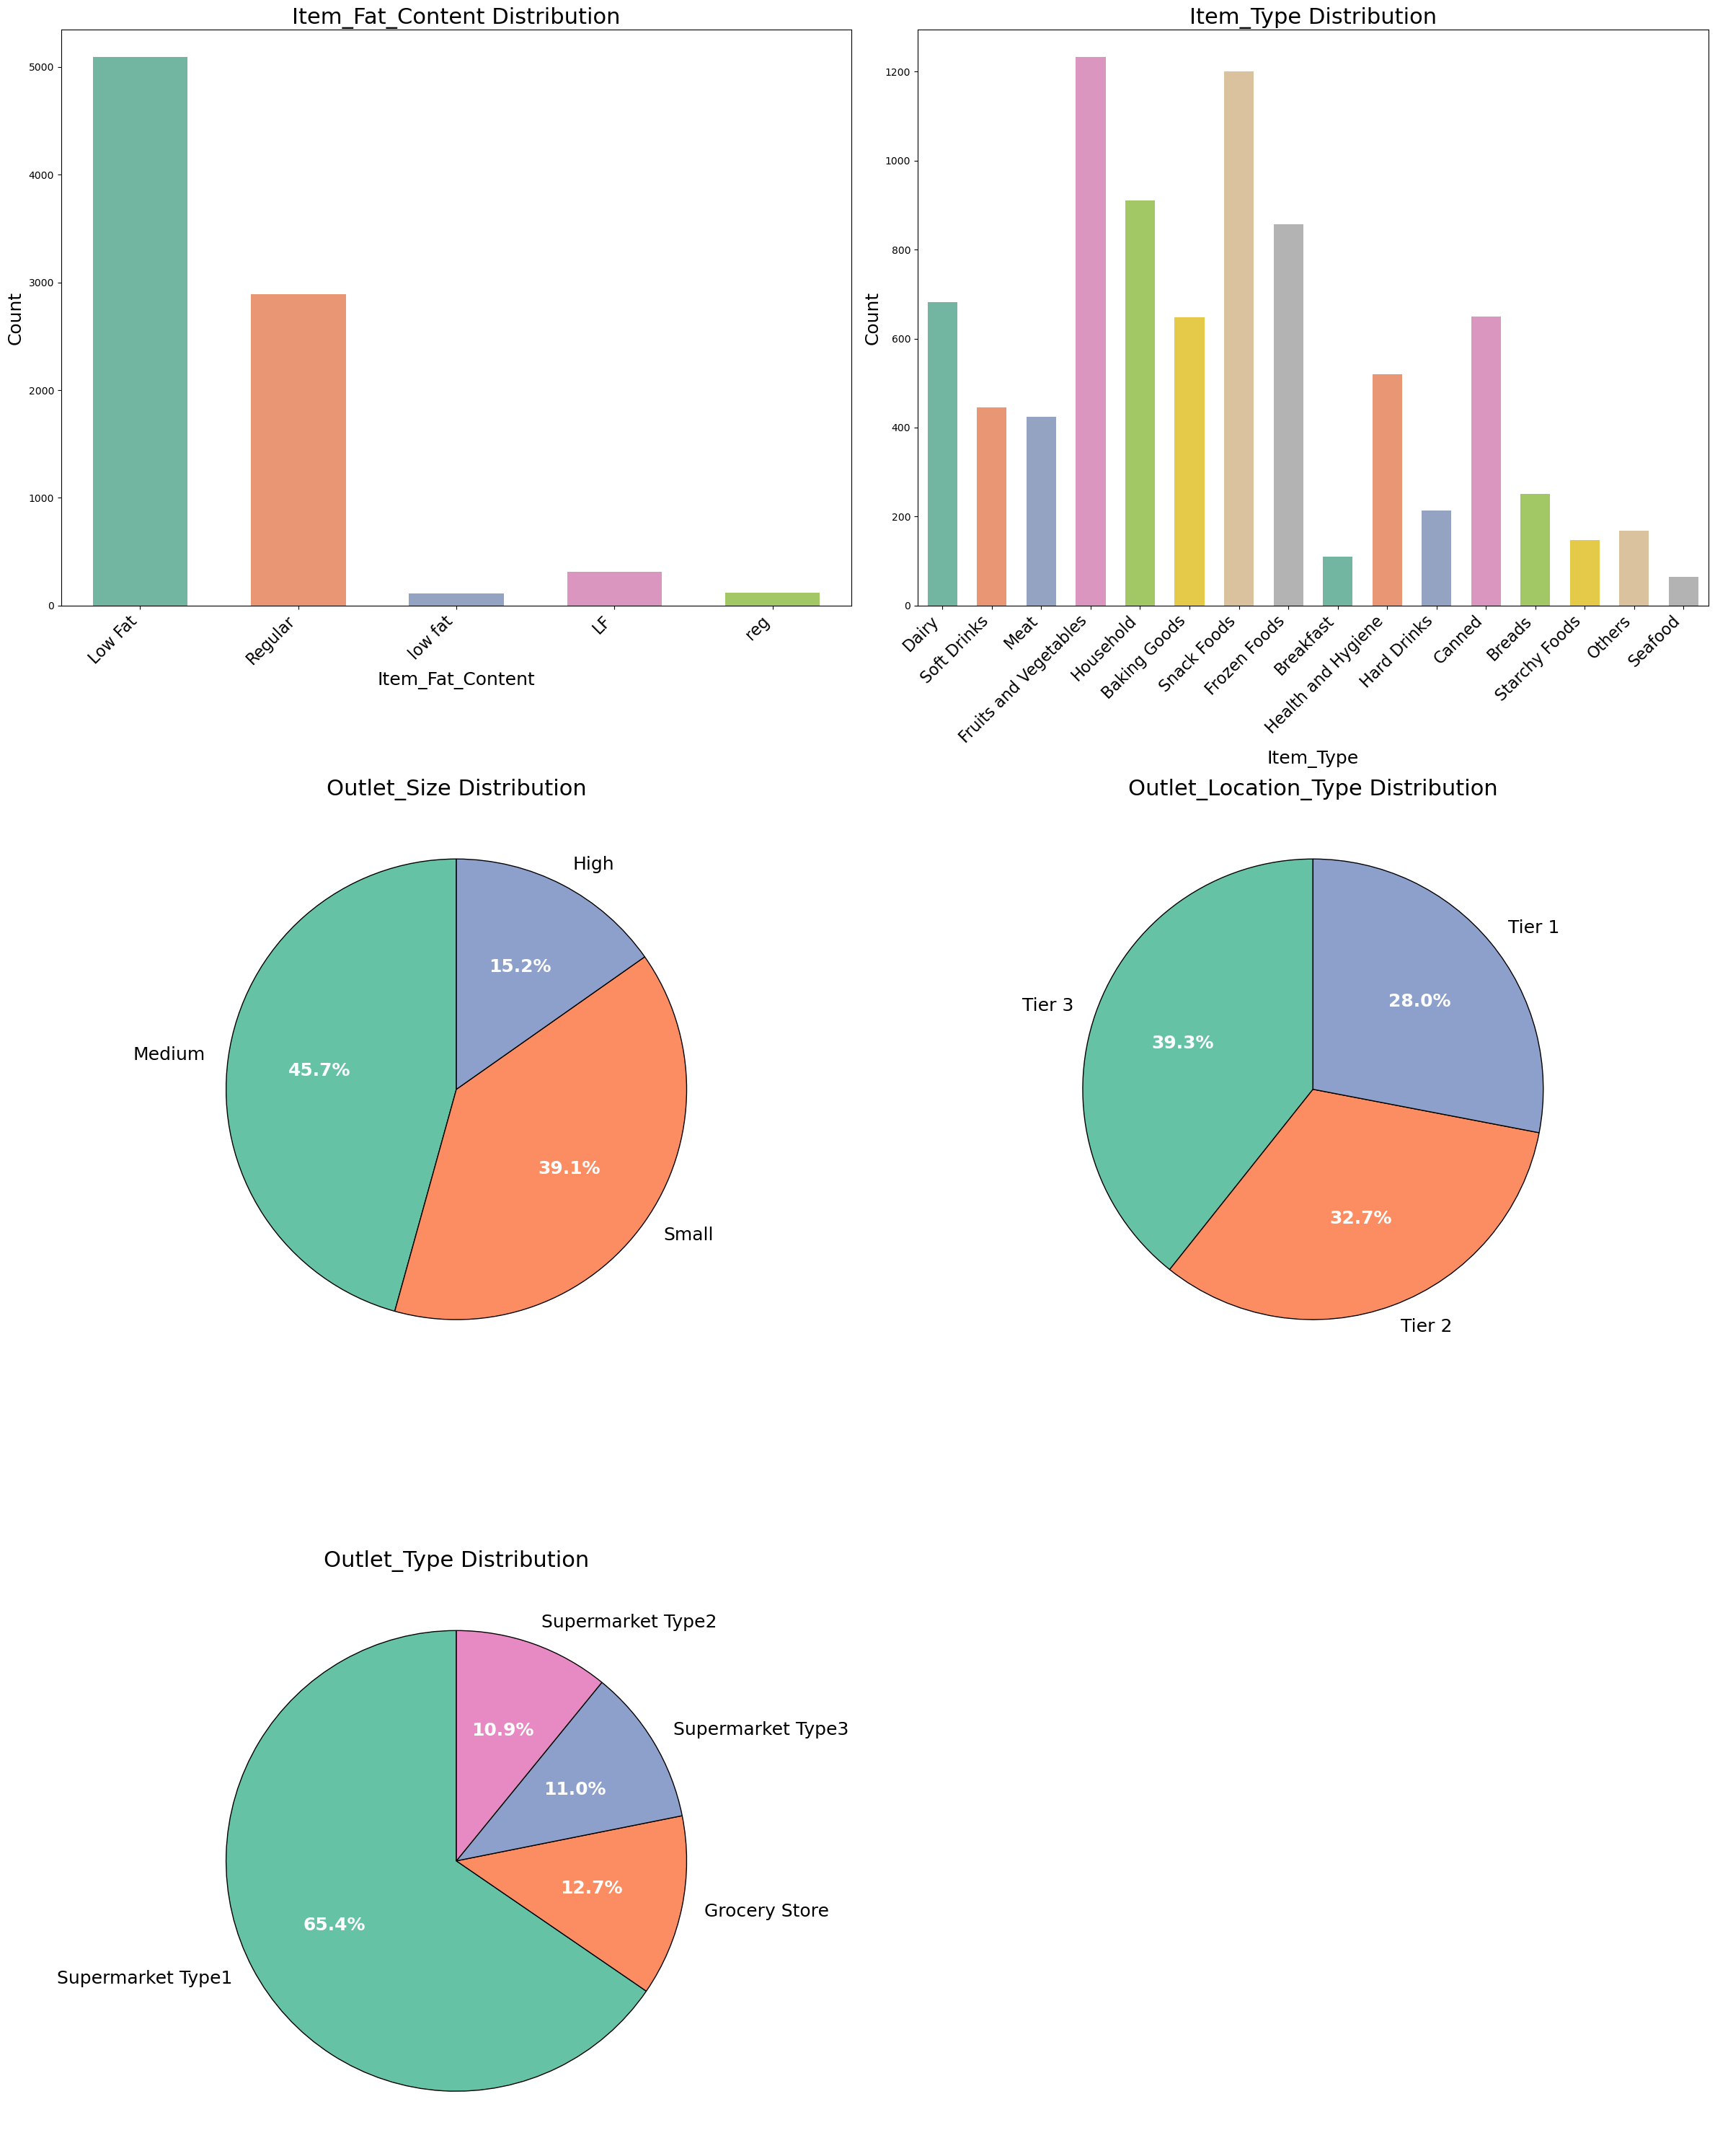

In [19]:
# Create subplots with appropriate figure size
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(24, 30))

# Loop through each categorical column and plot bar or pie charts
for index, col in enumerate(categorical_cols_to_display):
    r = index // 2
    c = index % 2
    if col in ['Item_Fat_Content', 'Item_Type']:
        # Bar chart for 'Item_Fat_Content' and 'Item_Type'
        g = sns.countplot(data=df, x=col, ax=ax[r][c], palette="Set2", width=0.6)
        g.set_xticklabels(g.get_xticklabels(), rotation=45, ha="right", fontsize=16)
        ax[r][c].set_title(f'{col} Distribution', fontsize=22)
        ax[r][c].set_ylabel('Count', fontsize=18)
        ax[r][c].set_xlabel(col, fontsize=18)
    else:
        # Pie chart for the other categorical columns
        wedges, texts, autotexts = ax[r][c].pie(df[col].value_counts(), labels=df[col].value_counts().index, 
                                                autopct='%1.1f%%', startangle=90, 
                                                colors=sns.color_palette("Set2", len(df[col].value_counts().index)),
                                                textprops={'fontsize': 18}, wedgeprops={'linewidth': 1, 'edgecolor': 'black'})

        # Set properties for better readability
        for text in texts:
            text.set_fontsize(18)
        for autotext in autotexts:
            autotext.set_fontsize(18)
            autotext.set_color('white')
            autotext.set_weight('bold')

        ax[r][c].set_title(f'{col} Distribution', fontsize=22)

# Turn off the last (6th) subplot in the layout
ax[2][1].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

**Observations:**
- The Item_Fat_Content column must be cleaned because there are some entry errors:
    * 'Low Fat', 'low fat' and 'LF' should be the same category
    * Similarly 'Regular' and 'reg' should the same
Another remark in this column is that 'Low Fat' item category is greater than 'Regular' one.

- There are 16 different categories in the the Item_type feature. I think it's a lot. May be in the feature engineering section we can try to group them into categories. For example grouping: 
    * 'Soft Drinks' and 'Hard Drinks' into a 'Drinks' category or
    * 'Snack Foods', 'Frozen Foods', 'Snarchy Foods' and 'Seafood' into a 'Foods' category.
    
- To encode the Outlet_Location_Type feature, we just have to extract the last character i.e:
    * 'Tier 1' ---> 1
    * 'Tier 2' ---> 2
    * 'Tier 3' ---> 3

## Bivariate Analysis

### Numerical-Numerical

In [20]:
Target = "Item_Outlet_Sales"

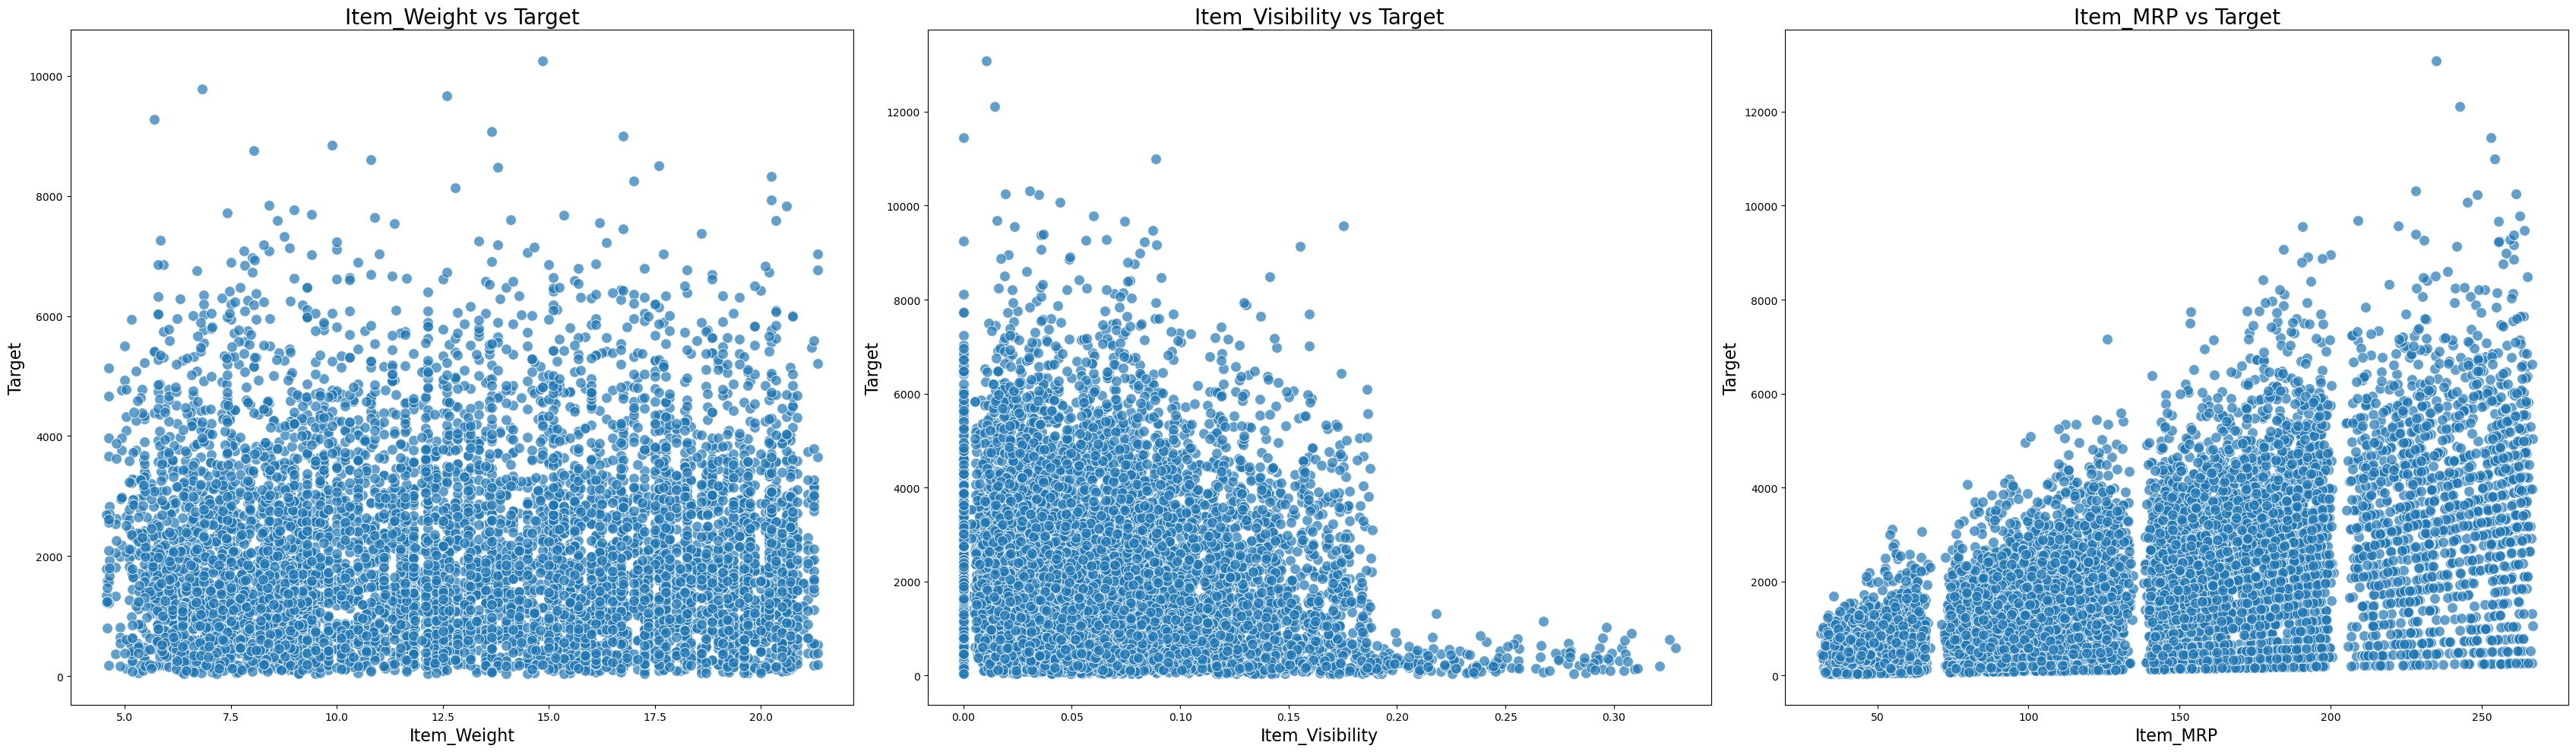

In [21]:
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(34, 10))

# Loop through the selected columns and plot scatter plots
for index, col in enumerate(['Item_Weight', 'Item_Visibility', 'Item_MRP']):
    sns.scatterplot(data=df, x=col, y=Target, ax=ax[index], s=100, alpha=0.7)
    ax[index].set_title(f'{col} vs Target', fontsize=20)
    ax[index].set_xlabel(col, fontsize=16)
    ax[index].set_ylabel('Target', fontsize=16)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

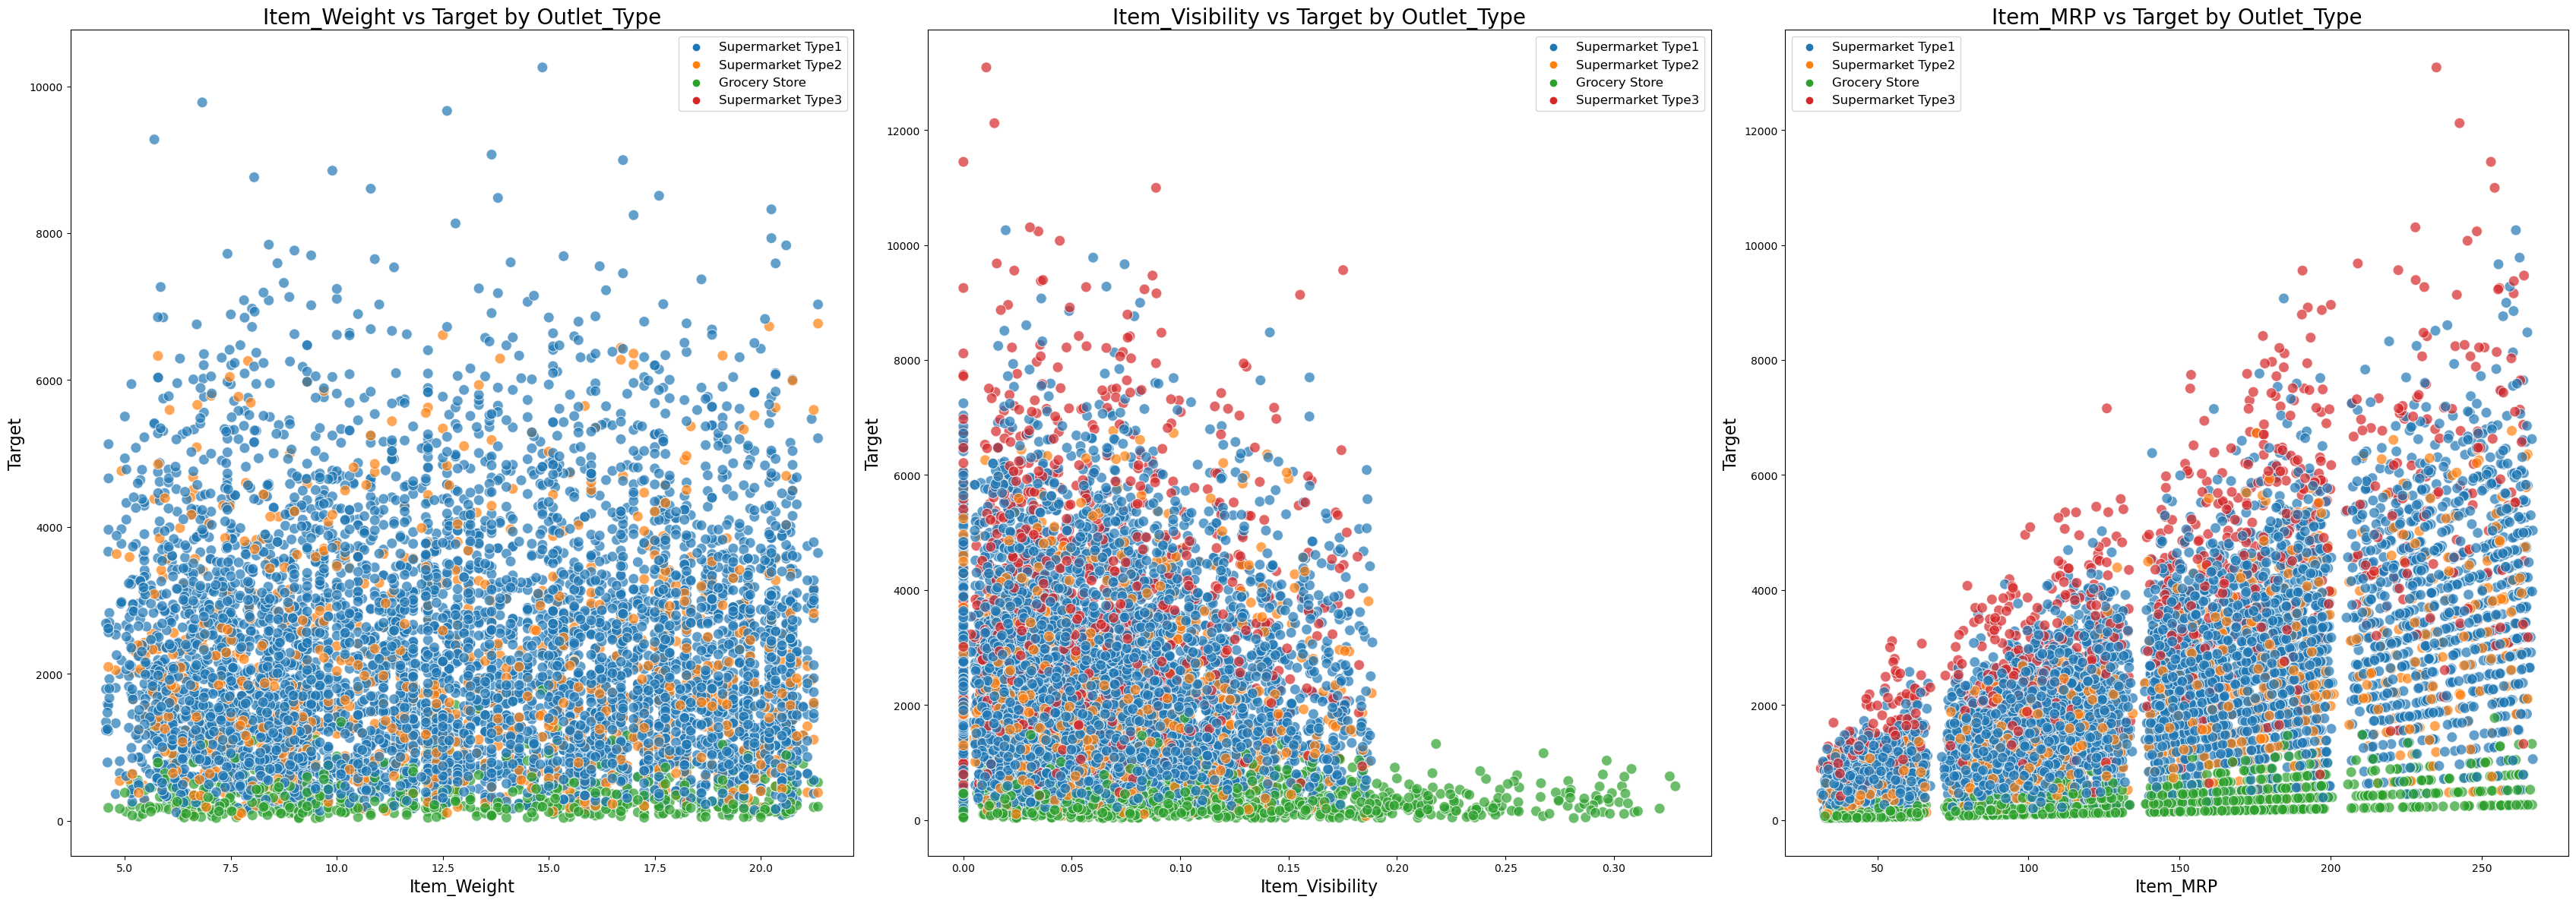

In [22]:
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(34, 12))

# Loop through the selected columns and plot scatter plots with hue
for index, col in enumerate(['Item_Weight', 'Item_Visibility', 'Item_MRP']):
    sns.scatterplot(data=df, x=col, y=Target, hue='Outlet_Type', ax=ax[index], s=100, alpha=0.7)
    ax[index].set_title(f'{col} vs Target by Outlet_Type', fontsize=20)
    ax[index].set_xlabel(col, fontsize=16)
    ax[index].set_ylabel('Target', fontsize=16)
    ax[index].legend(loc='best', fontsize=12)  # Adjust the legend size and position for better readability

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

<Axes: >

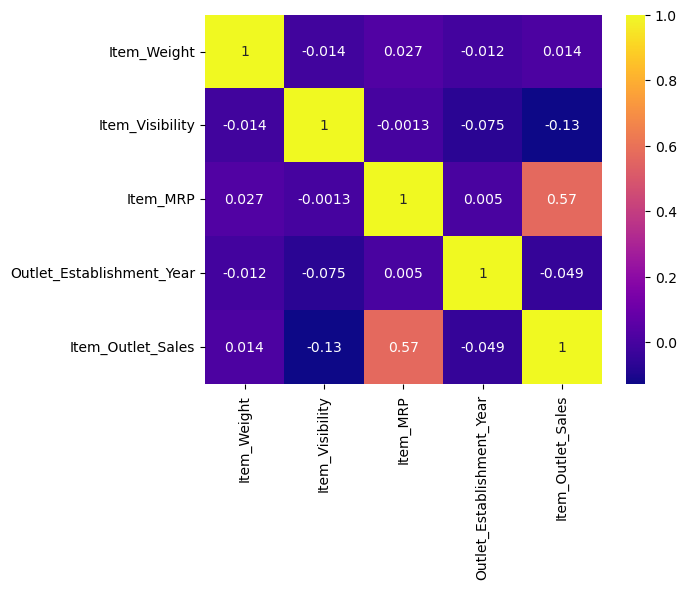

In [23]:
sns.heatmap(df.corr(), annot=True,cmap= 'plasma')

### Numerical-Categorical

<Axes: xlabel='Outlet_Size', ylabel='Item_Outlet_Sales'>

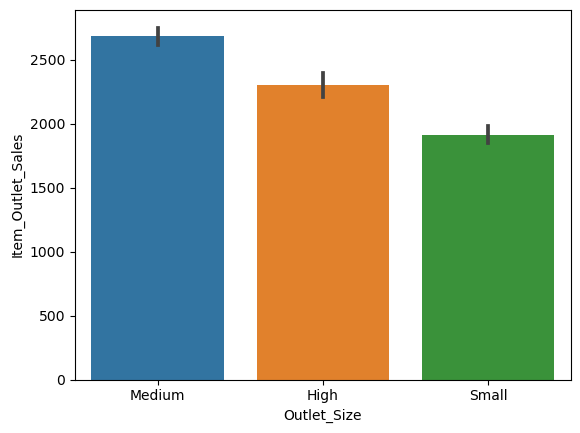

In [24]:
sns.barplot(data=df, x='Outlet_Size', y=Target)

In [25]:
df.Outlet_Establishment_Year

0       1999
1       2009
2       1999
3       1998
4       1987
        ... 
8518    1987
8519    2002
8520    2004
8521    2009
8522    1997
Name: Outlet_Establishment_Year, Length: 8523, dtype: int64

# Missing Value Treatment

- **OutLet_Size** is a catogerial column, we can use the **mode** to fill the missing values.
- **Item_weight** is a numeric column and after visualizations, we can see clearly that there are no outliers in this feature. So we can replace missing values with its **mean**.

In [26]:
df['Outlet_Size'] = df.Outlet_Size.fillna(df.Outlet_Size.dropna().mode()[0]) 
df['Item_Weight'] = df.Item_Weight.fillna(df.Item_Weight.mean())

In [27]:
df.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

# Feature Engineering

Upper limit:  0.195979015
Lower limit:  -0.07440424500000001


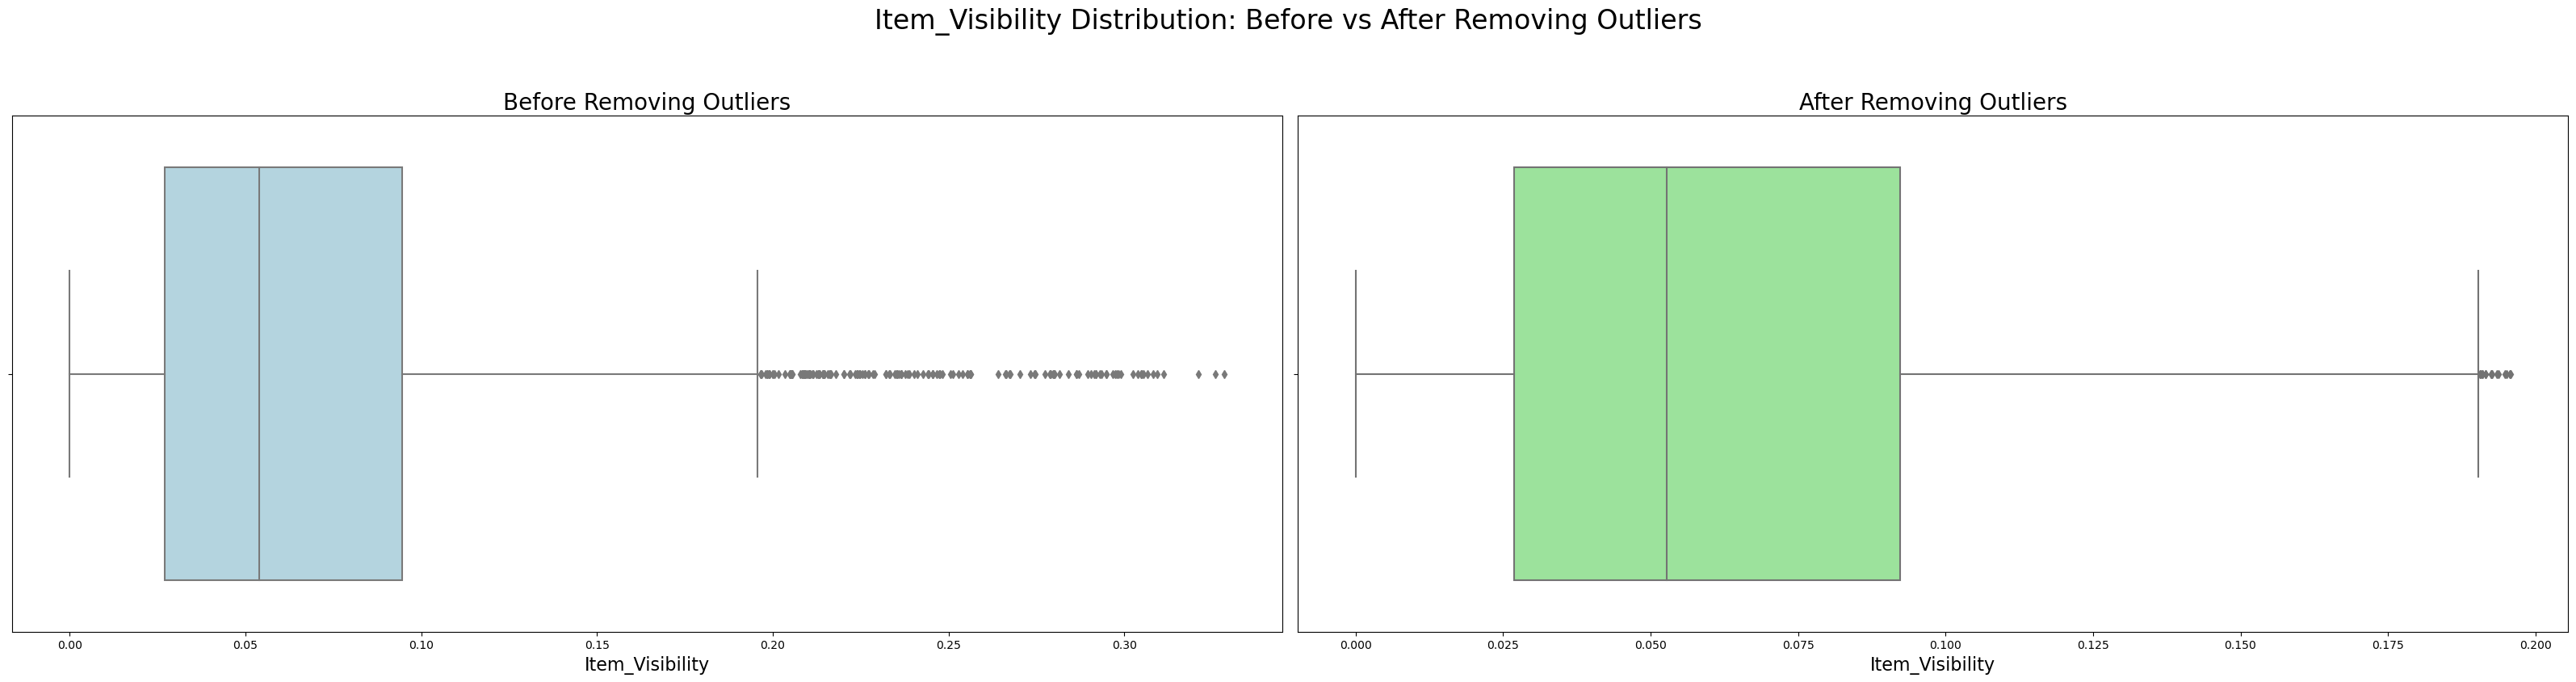

In [28]:
# Function to detect outliers using the IQR method
def detect_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    upper_limit = Q3 + 1.5 * IQR
    lower_limit = Q1 - 1.5 * IQR
    return upper_limit, lower_limit

# Detecting outliers for the 'Item_Visibility' feature
upper, lower = detect_outliers(df, "Item_Visibility")
print("Upper limit: ", upper)
print("Lower limit: ", lower)

# Setting up the subplots
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(32, 8))

# Boxplot before removing outliers
sns.boxplot(x=df['Item_Visibility'], ax=ax[0], color='lightblue')
ax[0].set_title('Before Removing Outliers', fontsize=20)
ax[0].set_xlabel('Item_Visibility', fontsize=16)

# Removing outliers using the IQR method
df = df[(df['Item_Visibility'] > lower) & (df['Item_Visibility'] < upper)] 

# Boxplot after removing outliers
sns.boxplot(x=df['Item_Visibility'], ax=ax[1], color='lightgreen')
ax[1].set_title('After Removing Outliers', fontsize=20)
ax[1].set_xlabel('Item_Visibility', fontsize=16)

# Set the overall title for the figure
plt.suptitle('Item_Visibility Distribution: Before vs After Removing Outliers', fontsize=24, y=1.05)
plt.tight_layout()
plt.show()

Upper limit:  6499.2067
Lower limit:  -2499.7460999999994


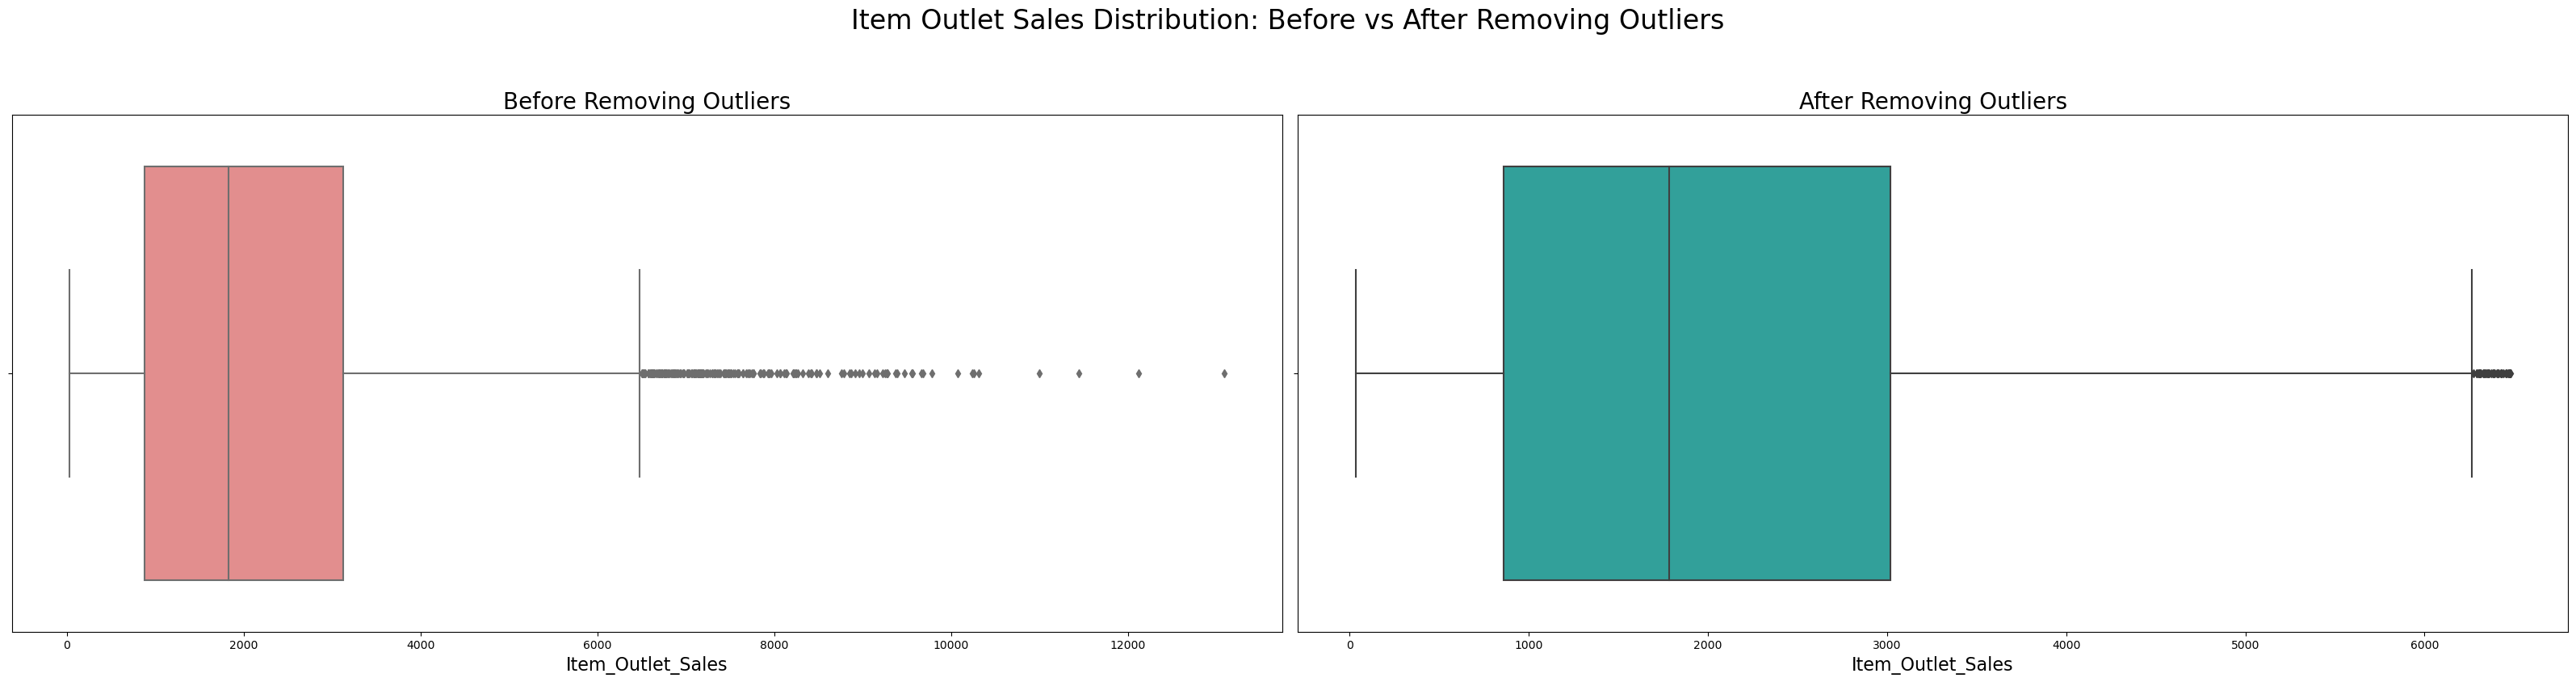

In [29]:
# Function to detect outliers using the IQR method
def detect_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    upper_limit = Q3 + 1.5 * IQR
    lower_limit = Q1 - 1.5 * IQR
    return upper_limit, lower_limit

# Detecting outliers for the 'Item_Outlet_Sales' feature
upper, lower = detect_outliers(df, "Item_Outlet_Sales")
print("Upper limit: ", upper)
print("Lower limit: ", lower)

# Setting up the subplots
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(32, 8))

# Boxplot before removing outliers
sns.boxplot(x=df['Item_Outlet_Sales'], ax=ax[0], color='lightcoral')
ax[0].set_title('Before Removing Outliers', fontsize=20)
ax[0].set_xlabel('Item_Outlet_Sales', fontsize=16)

# Removing outliers using the IQR method
df = df[(df['Item_Outlet_Sales'] > lower) & (df['Item_Outlet_Sales'] < upper)]

# Boxplot after removing outliers
sns.boxplot(x=df['Item_Outlet_Sales'], ax=ax[1], color='lightseagreen')
ax[1].set_title('After Removing Outliers', fontsize=20)
ax[1].set_xlabel('Item_Outlet_Sales', fontsize=16)

# Set the overall title for the figure
plt.suptitle('Item Outlet Sales Distribution: Before vs After Removing Outliers', fontsize=24, y=1.05)
plt.tight_layout()
plt.show()

# Encoding Categorical Variables

## Label Encoding

In [30]:
# Let's correct the errors in the Item_Fat_Content column

df['Item_Fat_Content'] = df['Item_Fat_Content'].map({'Low Fat' :'Low Fat',
                                                           'low fat' :"Low Fat",
                                                           'LF'      :"Low Fat",
                                                           'Regular' :'Regular',
                                                           'reg'     :"Regular"
                                                          })

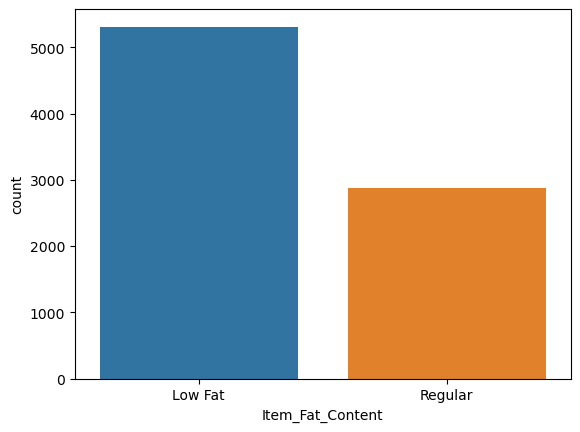

In [31]:
sns.countplot(x=df['Item_Fat_Content']);

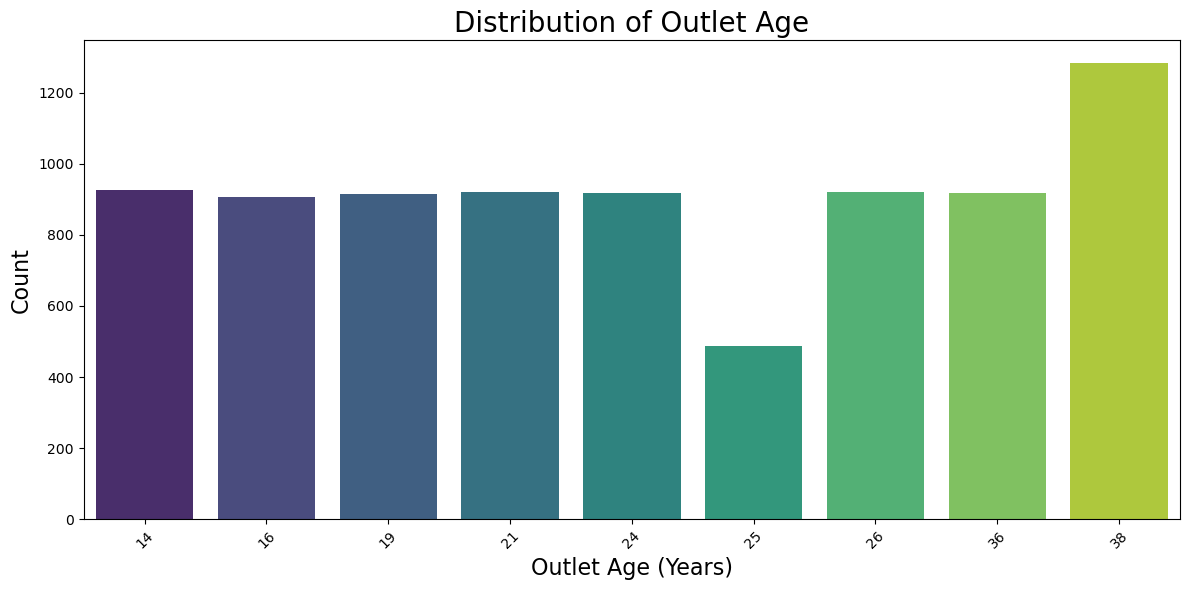

In [32]:
# Calculate the outlet age and create a new column
df['Outlet_Age'] = 2023 - df['Outlet_Establishment_Year']

# Drop the old establishment year columns
df.drop(columns=['Outlet_Establishment_Year'], inplace=True)

# Plot the distribution of Outlet_Age
plt.figure(figsize=(12, 6))
sns.countplot(x=df['Outlet_Age'], palette='viridis')
plt.title('Distribution of Outlet Age', fontsize=20)
plt.xlabel('Outlet Age (Years)', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

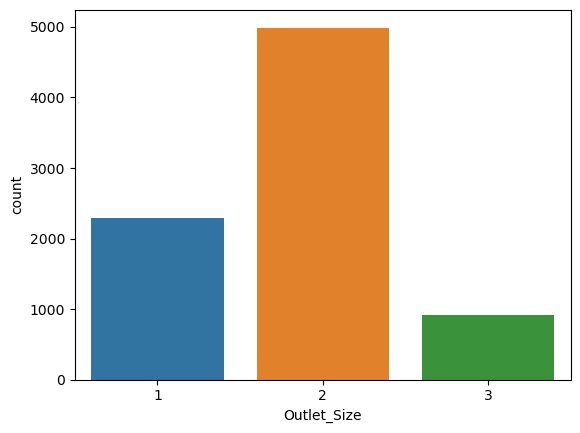

In [33]:
df['Outlet_Size'] = df['Outlet_Size'].map({'Small'  : 1,
                                                 'Medium' : 2,
                                                 'High'   : 3
                                                 }).astype(int)

sns.countplot(x=df['Outlet_Size']);

<Axes: xlabel='Outlet_Location_Type', ylabel='count'>

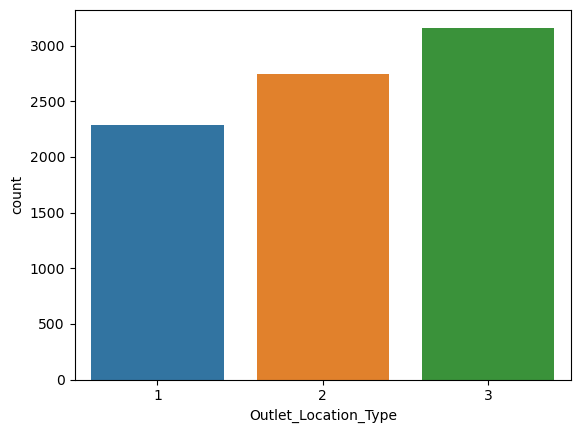

In [34]:
# Outlet_Location_Type feature encoding by getting the last character and converting to int type

df['Outlet_Location_Type'] = df['Outlet_Location_Type'].str[-1:].astype(int)
sns.countplot(x=df['Outlet_Location_Type'])

In the Item_Type feature, there are 16 catgories but when we look closely to Item_Identifier_Categories, it has first two characters defining the item type, these are:
- **FD** for probably **Food**;
- **DR** for probably **Drinks**;
- **NC** for probably **Non-Consumables**. 

**So we'll drop the Item_Identifier feature and create a new column containing these categories.**

<Axes: xlabel='Item_Identifier_Categories', ylabel='count'>

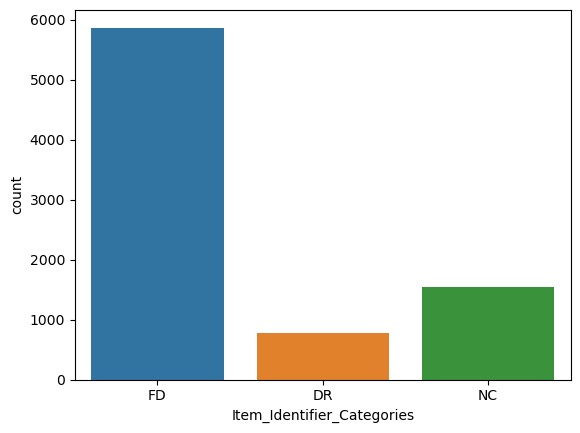

In [35]:
df['Item_Identifier_Categories'] = df['Item_Identifier'].str[0:2] #.astype(int)

sns.countplot(x=df['Item_Identifier_Categories'])

In [36]:
df.head()

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30          Low Fat         0.016047   
1           DRC01         5.92          Regular         0.019278   
2           FDN15        17.50          Low Fat         0.016760   
3           FDX07        19.20          Regular         0.000000   
4           NCD19         8.93          Low Fat         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  Outlet_Size  \
0                  Dairy  249.8092            OUT049            2   
1            Soft Drinks   48.2692            OUT018            2   
2                   Meat  141.6180            OUT049            2   
3  Fruits and Vegetables  182.0950            OUT010            2   
4              Household   53.8614            OUT013            3   

   Outlet_Location_Type        Outlet_Type  Item_Outlet_Sales  Outlet_Age  \
0                     1  Supermarket Type1          3735.1380          24   
1                     3  Supermarket Type2           443.4228          14   
2                     1  Supermarket Type1          2097.2700          24   
3                     3      Grocery Store           732.3800          25   
4                     3  Supermarket Type1           994.7052          36   

  Item_Identifier_Categories  
0                         FD  
1                         DR  
2                         FD  
3                         FD  
4                         NC

In [37]:
#Label Encoder for Ordinate Data

encoder = LabelEncoder()
ordinal_features = ['Item_Fat_Content', 'Outlet_Type', 'Outlet_Location_Type']

for feature in ordinal_features:
    df[feature] = encoder.fit_transform(df[feature])
  
df.shape

(8193, 13)

In [38]:
df.head()

Item_Identifier  Item_Weight  Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30                 0         0.016047   
1           DRC01         5.92                 1         0.019278   
2           FDN15        17.50                 0         0.016760   
3           FDX07        19.20                 1         0.000000   
4           NCD19         8.93                 0         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  Outlet_Size  \
0                  Dairy  249.8092            OUT049            2   
1            Soft Drinks   48.2692            OUT018            2   
2                   Meat  141.6180            OUT049            2   
3  Fruits and Vegetables  182.0950            OUT010            2   
4              Household   53.8614            OUT013            3   

   Outlet_Location_Type  Outlet_Type  Item_Outlet_Sales  Outlet_Age  \
0                     0            1          3735.1380          24   
1                     2            2           443.4228          14   
2                     0            1          2097.2700          24   
3                     2            0           732.3800          25   
4                     2            1           994.7052          36   

  Item_Identifier_Categories  
0                         FD  
1                         DR  
2                         FD  
3                         FD  
4                         NC

## One Hot Encoding

In [39]:
# One Hot Encoding for 'Item_Type' variable

df = pd.get_dummies(df, columns=['Item_Type', 'Item_Identifier_Categories', 'Outlet_Identifier'], drop_first=True)

In [40]:
df.head()

Item_Identifier  Item_Weight  Item_Fat_Content  Item_Visibility  Item_MRP  \
0           FDA15         9.30                 0         0.016047  249.8092   
1           DRC01         5.92                 1         0.019278   48.2692   
2           FDN15        17.50                 0         0.016760  141.6180   
3           FDX07        19.20                 1         0.000000  182.0950   
4           NCD19         8.93                 0         0.000000   53.8614   

   Outlet_Size  Outlet_Location_Type  Outlet_Type  Item_Outlet_Sales  \
0            2                     0            1          3735.1380   
1            2                     2            2           443.4228   
2            2                     0            1          2097.2700   
3            2                     2            0           732.3800   
4            3                     2            1           994.7052   

   Outlet_Age  ...  Item_Identifier_Categories_NC  Outlet_Identifier_OUT013  \
0          24  ...                              0                         0   
1          14  ...                              0                         0   
2          24  ...                              0                         0   
3          25  ...                              0                         0   
4          36  ...                              1                         1   

   Outlet_Identifier_OUT017  Outlet_Identifier_OUT018  \
0                         0                         0   
1                         0                         1   
2                         0                         0   
3                         0                         0   
4                         0                         0   

   Outlet_Identifier_OUT019  Outlet_Identifier_OUT027  \
0                         0                         0   
1                         0                         0   
2                         0                         0   
3                         0                         0   
4                         0                         0   

   Outlet_Identifier_OUT035  Outlet_Identifier_OUT045  \
0                         0                         0   
1                         0                         0   
2                         0                         0   
3                         0                         0   
4                         0                         0   

   Outlet_Identifier_OUT046  Outlet_Identifier_OUT049  
0                         0                         1  
1                         0                         0  
2                         0                         1  
3                         0                         0  
4                         0                         0  

[5 rows x 36 columns]

## PreProcessing Data

In [41]:
# Let's drop useless columns
df.drop(labels=['Item_Identifier'], axis=1, inplace=True) 

In [42]:
# Feature selection
X = df.drop(['Item_Outlet_Sales'], axis=1)  
y = df['Item_Outlet_Sales']

In [43]:
X.head()

Item_Weight  Item_Fat_Content  Item_Visibility  Item_MRP  Outlet_Size  \
0         9.30                 0         0.016047  249.8092            2   
1         5.92                 1         0.019278   48.2692            2   
2        17.50                 0         0.016760  141.6180            2   
3        19.20                 1         0.000000  182.0950            2   
4         8.93                 0         0.000000   53.8614            3   

   Outlet_Location_Type  Outlet_Type  Outlet_Age  Item_Type_Breads  \
0                     0            1          24                 0   
1                     2            2          14                 0   
2                     0            1          24                 0   
3                     2            0          25                 0   
4                     2            1          36                 0   

   Item_Type_Breakfast  ...  Item_Identifier_Categories_NC  \
0                    0  ...                              0   
1                    0  ...                              0   
2                    0  ...                              0   
3                    0  ...                              0   
4                    0  ...                              1   

   Outlet_Identifier_OUT013  Outlet_Identifier_OUT017  \
0                         0                         0   
1                         0                         0   
2                         0                         0   
3                         0                         0   
4                         1                         0   

   Outlet_Identifier_OUT018  Outlet_Identifier_OUT019  \
0                         0                         0   
1                         1                         0   
2                         0                         0   
3                         0                         0   
4                         0                         0   

   Outlet_Identifier_OUT027  Outlet_Identifier_OUT035  \
0                         0                         0   
1                         0                         0   
2                         0                         0   
3                         0                         0   
4                         0                         0   

   Outlet_Identifier_OUT045  Outlet_Identifier_OUT046  \
0                         0                         0   
1                         0                         0   
2                         0                         0   
3                         0                         0   
4                         0                         0   

   Outlet_Identifier_OUT049  
0                         1  
1                         0  
2                         1  
3                         0  
4                         0  

[5 rows x 34 columns]

In [44]:
y.head()

0    3735.1380
1     443.4228
2    2097.2700
3     732.3800
4     994.7052
Name: Item_Outlet_Sales, dtype: float64

In [45]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Model Building

## Linear Regression Model

In [46]:
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, y_train)

LinearRegression()

In [47]:
# Predictions for LinearRegression on the test data
lin_reg_predictions = lin_reg_model.predict(X_test)

In [48]:
print('Training score  : {}'.format(lin_reg_model.score(X_train, y_train)))
print('Test score      : {}'.format(lin_reg_model.score(X_test, y_test)))

Training score  : 0.5526937760381354
Test score      : 0.5429794477755583


In [49]:
# Evaluation
lin_reg_mse  = mean_squared_error(y_test , lin_reg_predictions)
lin_reg_rmse = math.sqrt(lin_reg_mse)
lin_reg_r2   = r2_score(y_test, lin_reg_predictions)

print('RMSE  \t         ----> {}'.format(lin_reg_rmse))
print('R2 Score         ----> {}'.format(lin_reg_r2))

RMSE  	         ----> 1032.122616182037
R2 Score         ----> 0.5429794477755583


**The LinearRegression model above give us a training accuracy and a test accuracy of about 55%. We also get an RMSE of about 1021.52 and a R2 score of 0.54.  
Let's try to add some polynomial features to see how good the Linear Regression performs. However, something else we would like to do is standardize our data. This scales our data down to a range between 0 and 1. This serves the purpose of letting us work with reasonable numbers when we raise to a power.**

In [50]:
steps = [
    ('scaler', StandardScaler()),
    ('poly',   PolynomialFeatures(degree=2)),
    ('model',  LinearRegression())
       ]

lin_reg_pipeline = Pipeline(steps)

lin_reg_pipeline.fit(X_train, y_train)

print('Training score  : {}'.format(lin_reg_pipeline.score(X_train, y_train)))
print('Test score      : {}'.format(lin_reg_pipeline.score(X_test, y_test)))

Training score  : 0.6022094458507793
Test score      : 0.559284186072872


**We got a better Training score of about 0.6022 but the Test score is 0.56 which means that the models start to overfit the data. If we increase the degree of PolynomialFeatures it will get worse.**

## Regularized Linear Regression

### Ridge Regression or l2 Regularization

**To understand Ridge Regression, we need to remind ourselves of what happens during gradient descent, when our model coefficients are trained. During training, our initial weights are updated according to a gradient update rule using a learning rate and a gradient. Ridge regression adds a penalty to the update, and as a result shrinks the size of our weights. This is implemented in scikit-learn as a class called Ridge.We will specify our regularization strength by passing in a parameter, alpha.The larger the value of alpha, the less variance your model will exhibit.**

In [51]:
steps = [
            ('scaler', StandardScaler()),
            ('poly'  , PolynomialFeatures(degree=2)),
            ('model' , Ridge(alpha=7, fit_intercept=True))
       ]

ridge_pipeline = Pipeline(steps)
ridge_pipeline.fit(X_train, y_train)

print('Training Score  : {}'.format(ridge_pipeline.score(X_train, y_train)))
print('Test Score      : {}'.format(ridge_pipeline.score(X_test, y_test)))

Training Score  : 0.6022186425200435
Test Score      : 0.5593909738791297


In [52]:
# Predictions for Ridge on the test data
ridge_predictions = ridge_pipeline.predict(X_test)

In [53]:
# Evaluation
ridge_mse  = mean_squared_error(y_test , ridge_predictions)
ridge_rmse = math.sqrt(ridge_mse)
ridge_r2   = r2_score(y_test, ridge_predictions)

print('Ridge RMSE  \t         ----> {}'.format(ridge_rmse))
print('Ridge R2 Score         ----> {}'.format(ridge_r2))

Ridge RMSE  	         ----> 1013.4215240084252
Ridge R2 Score         ----> 0.5593909738791297


### Lasso Regression or l1 Regularization

**By creating a polynomial model, we created additional features. The question we need to ask ourselves is which of our features are relevant to our model, and which are not.l1 regularization tries to answer this question by driving the values of certain coefficients down to 0. This eliminates the least important features in our model. We will create a pipeline similar to the one above, but using Lasso. You can play around with the value of alpha, which can range from 0.1 to 1.**

In [54]:
steps = [
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=2)),
            ('model', Lasso(alpha=0.2, fit_intercept=True))
        ]

lasso_pipeline = Pipeline(steps)

lasso_pipeline.fit(X_train, y_train)

print('Training score  : {}'    .format(lasso_pipeline.score(X_train, y_train)))
print('Test score      : {}'    .format(lasso_pipeline.score(X_test, y_test)))

Training score  : 0.6021840217408465
Test score      : 0.559788065108489


In [55]:
# Predictions for Lasso on the testset
lasso_predictions = lasso_pipeline.predict(X_test)

In [56]:
# Evaluation
lasso_mse  = mean_squared_error(y_test , lasso_predictions)
lasso_rmse = math.sqrt(lasso_mse)
lasso_r2   = r2_score(y_test, lasso_predictions)

print('Lasso RMSE  \t         ----> {}'.format(lasso_rmse))
print('Lasso R2 Score         ----> {}'.format(lasso_r2))

Lasso RMSE  	         ----> 1012.9647568015214
Lasso R2 Score         ----> 0.559788065108489


**Ridge and Lasso gives better results than LinearRegression.**

## RandomForest

In [57]:
rand_forest_model = RandomForestRegressor()
rand_forest_model.fit(X_train, y_train)

RandomForestRegressor()

In [58]:
# Predictions for XGBoost on the test data
rand_forest_predictions = rand_forest_model.predict(X_test)

In [59]:
print('Training score  : {}'.format(rand_forest_model.score(X_train, y_train)))
print('Test score      : {}'.format(rand_forest_model.score(X_test, y_test)))

Training score  : 0.9350458749069359
Test score      : 0.5330779548295249


In [60]:
# Evaluation
rand_forest_mse = mean_squared_error(y_test , rand_forest_predictions)
rand_forest_rmse = math.sqrt(rand_forest_mse)
rand_forest_r2 = r2_score(y_test, rand_forest_predictions)

print('RandomForest RMSE  \t       ----> {}'.format(rand_forest_rmse))
print('RandomForest R2 Score       ----> {}'.format(rand_forest_r2))

RandomForest RMSE  	       ----> 1043.2433348333407
RandomForest R2 Score       ----> 0.5330779548295249


**The gap between the training score and the test score is huge so RandomForest is overfitting the data. We can handle this issue with hyperparameter tuning.**

## XGBoost

In [61]:
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [62]:
# Predictions for XGBoost on the test data
xgb_predictions = xgb_model.predict(X_test)

In [63]:
print('XGBoost Training score  : {}'.format(xgb_model.score(X_train, y_train)))
print('XGBoost Test score      : {}'.format(xgb_model.score(X_test, y_test)))

XGBoost Training score  : 0.8536600927571982
XGBoost Test score      : 0.478850267810099


**XGBoost is also overfitting the data. We'll try after to tune the hyperparameters for XGBoost and see how the model performs.**

In [64]:
# Evaluation
xgb_mse = mean_squared_error(y_test , xgb_predictions)
xgb_rmse = math.sqrt(xgb_mse)
xgb_r2 = r2_score(y_test, xgb_predictions)

print('XGBoost RMSE  \t   ----> {}'.format(xgb_rmse))
print('XGBoost R2 Score   ----> {}'.format(xgb_r2))

XGBoost RMSE  	   ----> 1102.160109735981
XGBoost R2 Score   ----> 0.478850267810099


# Hyperparameter Tuning

### Ridge Regression

In [71]:
from sklearn.model_selection import GridSearchCV

ridge_params = {'model__alpha': [0.1, 1, 10, 100]}
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', Ridge())
])

ridge_cv = GridSearchCV(ridge_pipeline, param_grid=ridge_params, cv=5)
ridge_cv.fit(X_train, y_train)

print(f"Best Ridge Params: {ridge_cv.best_params_}")
print(f"Training Score  : {ridge_cv.score(X_train, y_train)}")
print(f"Test Score      : {ridge_cv.score(X_test, y_test)}")


Best Ridge Params: {'model__alpha': 100}
Training Score  : 0.6019673637284089
Test Score      : 0.5601606947287976


### Lasso Regression

In [72]:
lasso_params = {'model__alpha': [0.001, 0.01, 0.1, 1]}
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', Lasso(max_iter=10000))
])

lasso_cv = GridSearchCV(lasso_pipeline, param_grid=lasso_params, cv=5)
lasso_cv.fit(X_train, y_train)

print(f"Best Lasso Params: {lasso_cv.best_params_}")
print(f"Training Score  : {lasso_cv.score(X_train, y_train)}")
print(f"Test Score      : {lasso_cv.score(X_test, y_test)}")


Best Lasso Params: {'model__alpha': 1}
Training Score  : 0.6016243269249721
Test Score      : 0.5614555032856994


### Random Forest

In [73]:
from sklearn.model_selection import RandomizedSearchCV

rf_params = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

rand_forest_cv = RandomizedSearchCV(RandomForestRegressor(), param_distributions=rf_params, n_iter=20, cv=5, random_state=42)
rand_forest_cv.fit(X_train, y_train)

print(f"Best Random Forest Params: {rand_forest_cv.best_params_}")
print(f"Training Score  : {rand_forest_cv.score(X_train, y_train)}")
print(f"Test Score      : {rand_forest_cv.score(X_test, y_test)}")


Best Random Forest Params: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 10}
Training Score  : 0.6786960860604557
Test Score      : 0.5698562203263016


### XGBoost

In [75]:
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb_cv = RandomizedSearchCV(XGBRegressor(), param_distributions=xgb_params, n_iter=20, cv=5, random_state=42)
xgb_cv.fit(X_train, y_train)

print(f"Best XGBoost Params: {xgb_cv.best_params_}")
print(f"Training Score  : {xgb_cv.score(X_train, y_train)}")
print(f"Test Score      : {xgb_cv.score(X_test, y_test)}")


Best XGBoost Params: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Training Score  : 0.603796912724953
Test Score      : 0.5707672407640019


**These results indicate that Random Forest and XGBoost are the most promising models. However, further refinement and feature engineering could yield even better performance.**

In [77]:
 # Make predictions using the best XGBoost model
xgb_best_model = xgb_cv.best_estimator_
xgb_predictions = xgb_best_model.predict(X_test)

# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_rmse = math.sqrt(xgb_mse)
xgb_r2 = r2_score(y_test, xgb_predictions)

print(f"XGBoost RMSE  : {xgb_rmse}")
print(f"XGBoost R2 Score: {xgb_r2}")

XGBoost RMSE  : 1000.2529922226723
XGBoost R2 Score: 0.5707672407640019


In [78]:
import joblib

# Save the best XGBoost model to a file
joblib.dump(xgb_best_model, 'xgboost_best_model.pkl')


['xgboost_best_model.pkl']

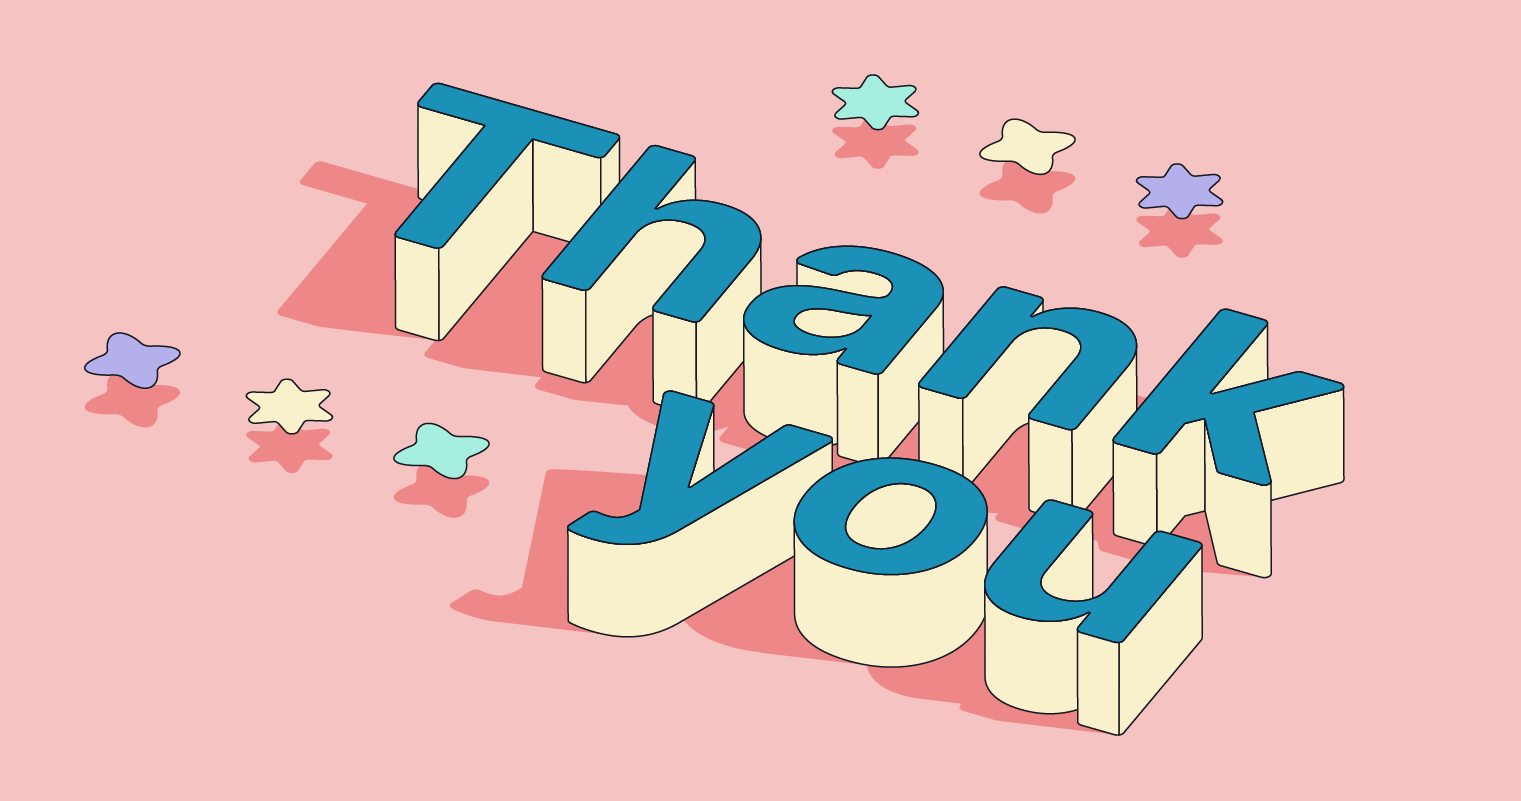